## Imports

In [1]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
%matplotlib inline

from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loading Data

In [2]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [3]:
master_dict = load_data_from_json('dataset/task1_headline_ABSA_train.json')

In [4]:
master_dict

{'1': {'info': [{'aspects': "['Corporate/Appointment']",
    'sentiment_score': '-0.374',
    'snippets': "['set to step down']",
    'target': 'Royal Mail'}],
  'sentence': 'Royal Mail chairman Donald Brydon set to step down'},
 '100': {'info': [{'aspects': "['Market/Volatility/Volatility']",
    'sentiment_score': '-0.827',
    'snippets': "['down from record high']",
    'target': 'Weir'}],
  'sentence': 'Slump in Weir leads FTSE down from record high'},
 '1000': {'info': [{'aspects': "['Corporate/Regulatory']",
    'sentiment_score': '0.549',
    'snippets': "['FDA approval for key new lung cancer pill']",
    'target': 'AstraZeneca'}],
  'sentence': 'AstraZeneca wins FDA approval for key new lung cancer pill'},
 '1002': {'info': [{'aspects': "['Corporate/Stategy']",
    'sentiment_score': '-0.266',
    'snippets': "['cut 945 jobs as part of 3-year restructuring plan']",
    'target': 'Lloyds'}],
  'sentence': 'UPDATE 1-Lloyds to cut 945 jobs as part of 3-year restructuring plan'},

## Into Data

In [5]:
def extract_data_from_dict(master_dict):
    id_sentence = []
    sentence = []
    aspect = []
    target = []
    for key in master_dict.keys():
        id_sentence.append(int(key))
        sentence.append(master_dict[key]['sentence'])
        temp_target=[]
        temp_aspect = []
        for element in master_dict[key]['info']:
            temp_target.append(element['target'])
            temp_aspect.append(eval(element['aspects']))
        target.append(temp_target)
        aspect.append(temp_aspect)
    return id_sentence,sentence,aspect,target

In [6]:
id_sentence,sentence,aspect,target = extract_data_from_dict(master_dict)

In [11]:
len(id_sentence),len(sentence),len(aspect),len(target)

(438, 438, 438, 438)

In [12]:
#converting data into flat str
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])

In [18]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(537, 537, 537, 537)

TODO: Need to fix Correct Aspect 3 and under threat

In [17]:
aspect_f_level1= []
aspect_f_level2=[]
for asp in aspect_f:
    try:
        aspect_f_level1.append(asp.split('/')[0])
        aspect_f_level2.append(asp.split('/')[1])
    except:
        print(asp)
# aspect_f

Correct Aspect 3
under threat


In [19]:
len(aspect_f_level2),len(aspect_f_level1)

(535, 537)

In [20]:
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))
n_label_level_1,n_label_level_2

(6, 34)

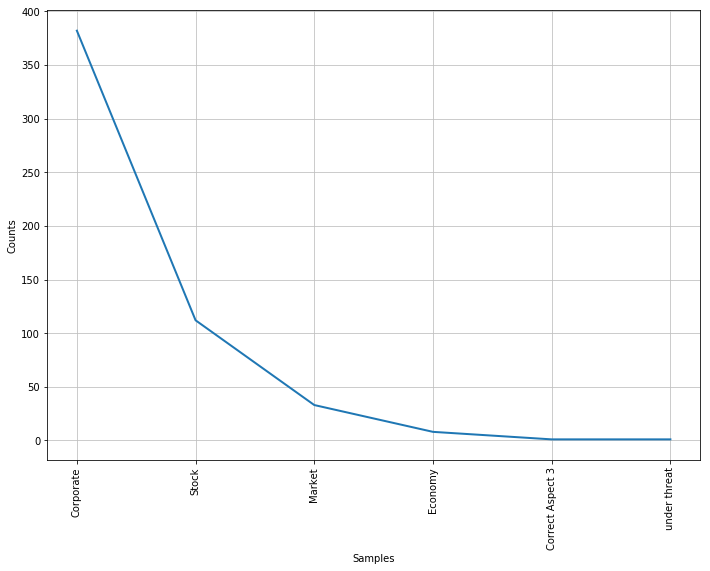

FreqDist({'Corporate': 382, 'Stock': 112, 'Market': 33, 'Economy': 8, 'Correct Aspect 3': 1, 'under threat': 1})


In [21]:
level1_freq = FreqDist(aspect_f_level1)
level1_freq.plot()
level1_freq.pprint()

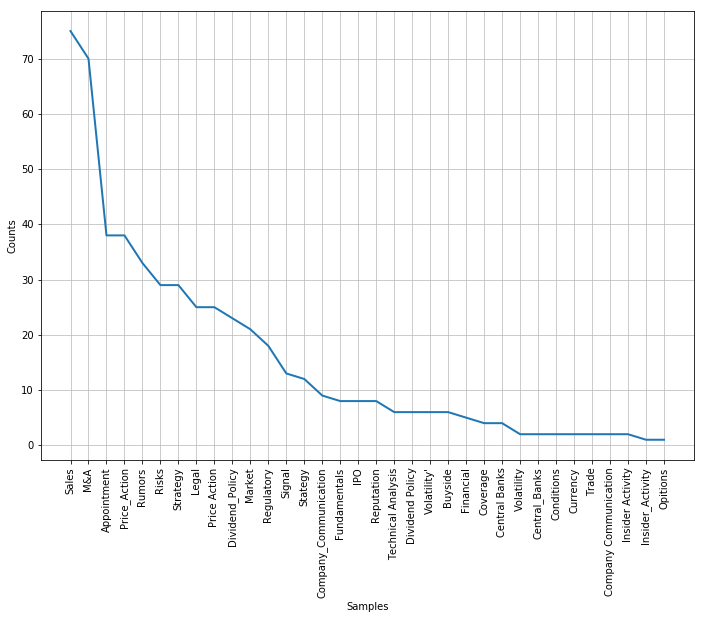

FreqDist({'Sales': 75, 'M&A': 70, 'Appointment': 38, 'Price_Action': 38, 'Rumors': 33, 'Risks': 29, 'Strategy': 29, 'Legal': 25, 'Price Action': 25, 'Dividend_Policy': 23, 'Market': 21, 'Regulatory': 18, 'Signal': 13, 'Stategy': 12, 'Company_Communication': 9, 'Fundamentals': 8, 'IPO': 8, 'Reputation': 8, 'Technical Analysis': 6, 'Dividend Policy': 6, "Volatility'": 6, 'Buyside': 6, 'Financial': 5, 'Coverage': 4, 'Central Banks': 4, 'Volatility': 2, 'Central_Banks': 2, 'Conditions': 2, 'Currency': 2, 'Trade': 2, 'Company Communication': 2, 'Insider Activity': 2, 'Insider_Activity': 1, 'Opitions': 1})


In [22]:
level2_freq = FreqDist(aspect_f_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [23]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [24]:
L2_L1_pair = get_level_pairs(aspect_f_level1,aspect_f_level2)
L1_L2_pair = get_level_pairs(aspect_f_level2,aspect_f_level1)

In [25]:
L1_L2_pair

{'Corporate': ['Appointment',
  'Central Banks',
  'Insider_Activity',
  'Dividend Policy',
  'Dividend_Policy',
  'Risks',
  'Trade',
  'Stategy',
  'Company_Communication',
  'Rumors',
  'Financial',
  'Coverage',
  'Price_Action',
  'Buyside',
  'Volatility',
  'Signal',
  'Technical Analysis',
  'Company Communication',
  'Regulatory',
  'Conditions',
  'Central_Banks',
  'M&A',
  'Reputation',
  'Strategy',
  'Currency',
  'Legal',
  'Opitions',
  'Fundamentals',
  'Price Action',
  'Market',
  'Insider Activity',
  'IPO',
  "Volatility'",
  'Sales'],
 'Correct Aspect 3': ['Sales'],
 'Economy': ['Buyside',
  'Risks',
  'M&A',
  'Price Action',
  'Rumors',
  'Dividend_Policy',
  'Strategy'],
 'Market': ['Appointment',
  'Price_Action',
  'Legal',
  'Risks',
  'IPO',
  'Regulatory',
  'Company_Communication',
  'M&A',
  'Dividend Policy',
  'Rumors',
  'Market',
  'Dividend_Policy',
  'Strategy',
  'Sales'],
 'Stock': ['Appointment',
  'Central Banks',
  'Dividend_Policy',
  'Risks'

In [26]:
L2_L1_pair

{'Appointment': ['Corporate', 'Market', 'Stock'],
 'Buyside': ['Economy', 'Corporate', 'Stock'],
 'Central Banks': ['Corporate', 'Stock'],
 'Central_Banks': ['Corporate'],
 'Company Communication': ['Corporate', 'Stock'],
 'Company_Communication': ['Market', 'Corporate', 'Stock'],
 'Conditions': ['Corporate'],
 'Coverage': ['Corporate', 'Stock'],
 'Currency': ['Corporate'],
 'Dividend Policy': ['Corporate', 'Market'],
 'Dividend_Policy': ['Market', 'Corporate', 'Economy', 'Stock'],
 'Financial': ['Corporate', 'Stock'],
 'Fundamentals': ['Corporate', 'Stock'],
 'IPO': ['Market', 'Corporate', 'Stock'],
 'Insider Activity': ['Corporate', 'Stock'],
 'Insider_Activity': ['Corporate'],
 'Legal': ['Market', 'Corporate', 'Stock'],
 'M&A': ['Stock', 'under threat', 'Economy', 'Corporate', 'Market'],
 'Market': ['Corporate', 'Market', 'Stock'],
 'Opitions': ['Corporate'],
 'Price Action': ['Economy', 'Corporate', 'Stock'],
 'Price_Action': ['Market', 'Corporate', 'Stock'],
 'Regulatory': ['Marke